In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 30 19:52:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data"
tsvData = os.path.join(dataDir,"WoSDataset_5736.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(5736, 4)


In [7]:
print(tsvData[0:15])

[['2' 'biochemistry'
  ' candidatus phytoplasma    16s rrna biosecurity taxonomy biodiversity vector seed transmission host range       '
  'phytoplasmas are insectvectored bacteria that cause disease in a wide range of plant species the increasing availability of molecular dna analyses expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasmaplant host associations and in the numbers of taxonomic groupings for phytoplasmas the widespread use of common names based on the diseases with which they are associated as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16s rrnaencoding gene complicates interpretation of the literature we explore this issue and related trends through a focus on australian pathosystems providing the first comprehensive compilation of information for this continent covering the phytoplasmas host plants vectors and diseases of the 33 16sr groups reported internati

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1292 1597 2847]


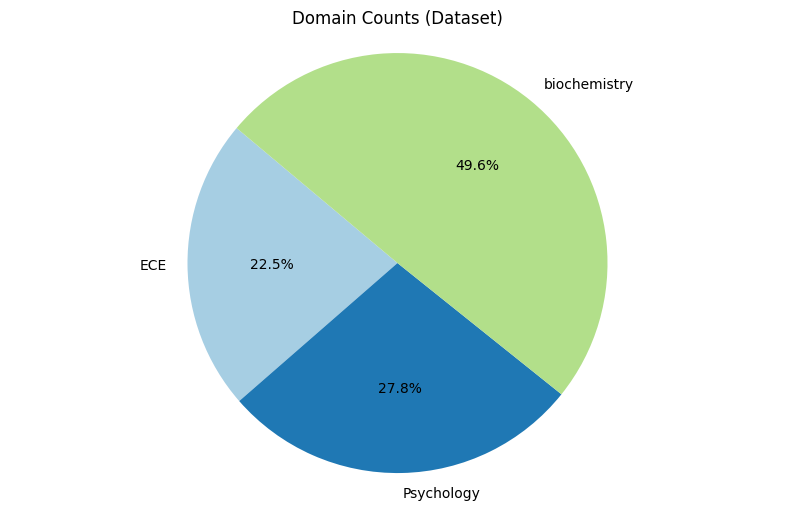

The domain ECE has 1292 records in the dataset.
The domain Psychology has 1597 records in the dataset.
The domain biochemistry has 2847 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  5736
Shape of abstracts:  (5736,)
['we previously demonstrated that serotonin 5ht and 5ht2a receptor 5ht2ar levels in platelets were up or downregulated after myocardial infarction mi associated with depression in this study we further evaluated the effects of pretreatment with ginseng fruit saponins gfs on the expression of 5ht and 5ht2ar in mi with or without depression eighty spraguedawley sd rats were treated with saline and gfs n40 per group the animals were then randomly divided into four subgroups sham mi depression and mi  depression n10 per subgroup protein levels of 5ht and 5ht2ar in the serum platelets and brain tissues were determined with elisa the results demonstrated that serum 5ht levels was significantly increased by gfs pretreatment in all subgroups except the sham subgroup when compared with salinetreated counterparts p001 in platelets gfs pretreatment significantly increased 5ht levels in all subgroups when compared with their respective saline

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

(4588, 4)
(1148, 4)
(4588, 4)
(1148, 4)
(230, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  4588
Shape of abstracts:  (4588,)
Number of keywords:  4588
Shape of keywords:  (4588,)
Number of domains:  4588
Shape of domains:  (4588,)
Number of labels:  4588
Shape of labels:  (4588,)
['the aim of the present study was to evaluate the functions of mir200c in the regulation of tumor growth and metastasis in renal cancer cells and to investigate the underlying mechanisms in this study mir200c was up and downregulated in two renal cancer cell lines namely achn and a498 and the proliferation colony formation migration and invasion of the cells were measured the expression levels of various mrnas and proteins were then analyzed using reverse transcriptionquantitative polymerase chain reaction and western blotting respectively it was found that mir200c suppressed proliferation migration and invasion of the renal cancer cells and conversely the inhibition of endogenous mir200c resulted in increased cell proliferation and metastasis furthermore a luciferase reporter

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1038 1269 2281]


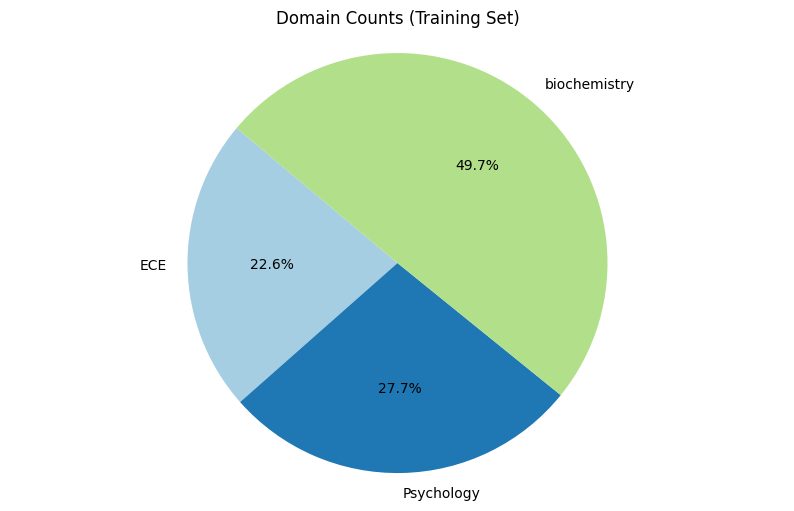

The domain ECE has 1038 records in the training set.
The domain Psychology has 1269 records in the training set.
The domain biochemistry has 2281 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  1148
Shape of abstracts:  (1148,)
Number of keywords:  1148
Shape of keywords:  (1148,)
Number of domains:  1148
Shape of domains:  (1148,)
Number of labels:  1148
Shape of labels:  (1148,)
['the cdna of crassostrea gigas hsp70 was cloned and rapid amplification of cdna race techniques were used the full length of hsp70 cdna was 2045 bp consisting of a 5 terminal untranslated region utr of 80 bp a 3 terminal utr 146 bp and an open reading frame ore of 1829 bp encoding deduced 620 amino acids the hsp70 cdna contained hsp70 family signatures atpgtp binding site motif tetrapeptide ggmp and conserved carboxyl terminal region eevd at cterminal of deduced amino acid sequence blast analysis revealed that the hsp70 gene has an extreme similarity of 989 with c gigas af144646 northern blotting was used to examine the expression of hsp70 mrna in the gill tissue of the oyster obtained from surface middle and bottom layers the hsp70 mrna observed the samples taken from middle 

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [254 328 566]


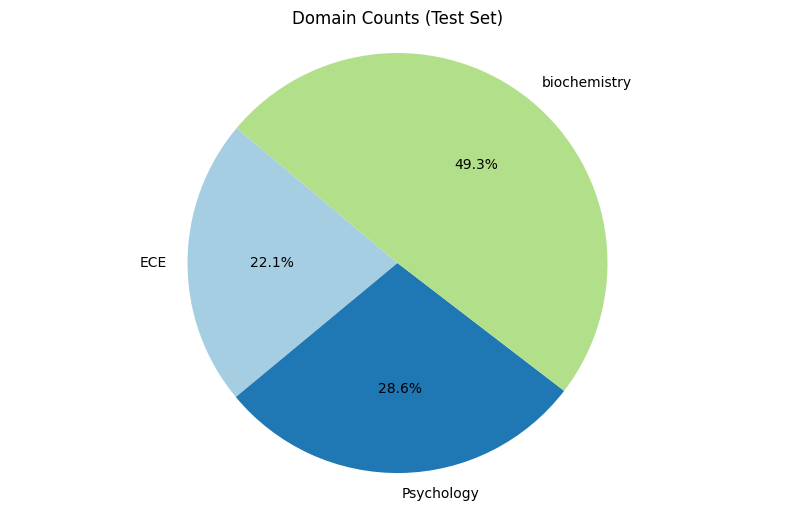

The domain ECE has 254 records in the test set.
The domain Psychology has 328 records in the test set.
The domain biochemistry has 566 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  230
Shape of abstracts:  (230,)
Number of keywords:  230
Shape of keywords:  (230,)
Number of domains:  230
Shape of domains:  (230,)
Number of labels:  230
Shape of labels:  (230,)
['background the rapid increase of extendedspectrum betalactamase esbl producing bacteria are a potential health hazard development of antimicrobial resistance in animal pathogens has serious implications for human health especially when such strains could be transmitted to human in this study the antimicrobial resistance due to esbl producing pseudomonas aeruginosa in the camel meat was investigated methods in this study meat samples from 200 healthy camels at two major abattoirs in egypt cairo and giza were collected following culture on cetrimide agar suspected p aeruginosa colonies were confirmed with a vitek 2 system biomerieux p aeruginosa isolates were phenotypically identified as esbl by double disk synergy test additionally antimicrobial susceptibility testing of esbl producin

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [ 48  73 109]


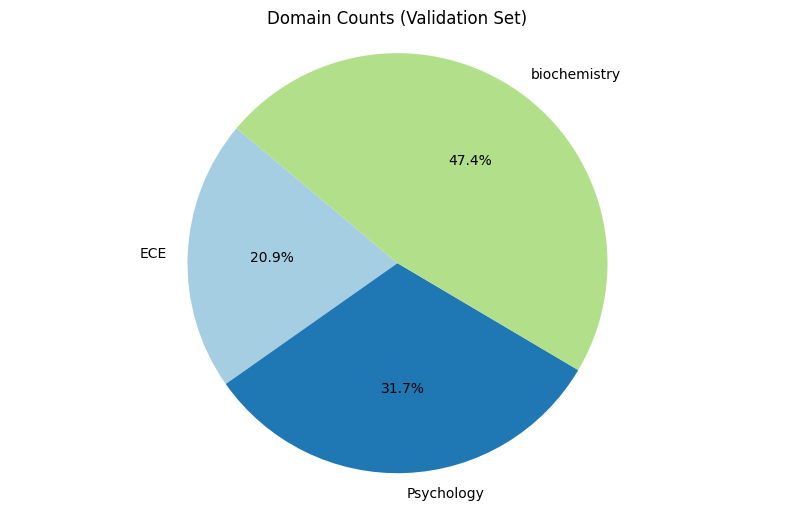

The domain ECE has 48 records in the vaidation set.
The domain Psychology has 73 records in the vaidation set.
The domain biochemistry has 109 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,2].tolist(), # keywords
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(4588, 4)
(1148, 4)
(230, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  4588
Label length  230
Label length  1148


In [22]:
print(np.unique(train_data[:,0]))

['0' '1' '2']


In [23]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

3


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [24]:
model.config

BertConfig {
  "_name_or_path": "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [27]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 144/144 [04:48<00:00,  2.00s/batch]


Epoch 1/20
  Train Loss: 0.39488274609256124
  Val Micro F1: 0.908695652173913
  Time: 4m 54s


Epoch 2/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 2/20
  Train Loss: 0.16443398661471698
  Val Micro F1: 0.908695652173913
  Time: 4m 60s


Epoch 3/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 3/20
  Train Loss: 0.10285752864405771
  Val Micro F1: 0.9217391304347826
  Time: 4m 60s


Epoch 4/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 4/20
  Train Loss: 0.05514758124142342
  Val Micro F1: 0.9130434782608695
  Time: 4m 60s


Epoch 5/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 5/20
  Train Loss: 0.03171875103402676
  Val Micro F1: 0.9173913043478261
  Time: 4m 60s


Epoch 6/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 6/20
  Train Loss: 0.016161907946702234
  Val Micro F1: 0.9260869565217392
  Time: 4m 60s


Epoch 7/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 7/20
  Train Loss: 0.008364486633733273
  Val Micro F1: 0.9173913043478261
  Time: 4m 60s


Epoch 8/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 8/20
  Train Loss: 0.005946713572636024
  Val Micro F1: 0.9217391304347826
  Time: 4m 60s


Epoch 9/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 9/20
  Train Loss: 0.004194592513310151
  Val Micro F1: 0.9130434782608695
  Time: 4m 60s


Epoch 10/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 10/20
  Train Loss: 0.0017011913443335895
  Val Micro F1: 0.9260869565217392
  Time: 4m 60s


Epoch 11/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 11/20
  Train Loss: 0.0018589456322186176
  Val Micro F1: 0.9260869565217392
  Time: 4m 60s


Epoch 12/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 12/20
  Train Loss: 0.0010578640369911024
  Val Micro F1: 0.9130434782608695
  Time: 4m 60s


Epoch 13/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 13/20
  Train Loss: 0.00020973126606804726
  Val Micro F1: 0.9173913043478261
  Time: 4m 60s


Epoch 14/20: 100%|██████████| 144/144 [04:55<00:00,  2.05s/batch]


Epoch 14/20
  Train Loss: 0.0008511603091644954
  Val Micro F1: 0.9173913043478261
  Time: 5m 0s


Epoch 15/20: 100%|██████████| 144/144 [04:55<00:00,  2.05s/batch]


Epoch 15/20
  Train Loss: 0.00014371148563441238
  Val Micro F1: 0.9260869565217392
  Time: 5m 0s


Epoch 16/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 16/20
  Train Loss: 0.003044184664607504
  Val Micro F1: 0.9260869565217392
  Time: 4m 60s


Epoch 17/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 17/20
  Train Loss: 0.0008817430238600031
  Val Micro F1: 0.9173913043478261
  Time: 5m 0s


Epoch 18/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 18/20
  Train Loss: 0.0006049735577562387
  Val Micro F1: 0.9173913043478261
  Time: 5m 0s


Epoch 19/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 19/20
  Train Loss: 0.0003382342573432753
  Val Micro F1: 0.9260869565217392
  Time: 4m 60s


Epoch 20/20: 100%|██████████| 144/144 [04:54<00:00,  2.05s/batch]


Epoch 20/20
  Train Loss: 4.154913204325162e-05
  Val Micro F1: 0.9173913043478261
  Time: 5m 0s


In [28]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[239  12   3]
 [ 21 280  27]
 [  2  15 549]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       254
           1       0.91      0.85      0.88       328
           2       0.95      0.97      0.96       566

    accuracy                           0.93      1148
   macro avg       0.92      0.92      0.92      1148
weighted avg       0.93      0.93      0.93      1148

Macro F1 Score: 0.9223994393307722
Micro F1 Score: 0.9303135888501742
Weighted F1 Score: 0.9297223243816812
Macro Precision: 0.9241507954064229
Micro Precision: 0.9303135888501742
Weighted Precision: 0.9299032749724827
Macro Recall: 0.9215226942620278
Micro Recall: 0.9303135888501742
Weighted Recall: 0.9303135888501742


In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BlueBERT_WoS_Keywords_5736')

In [ ]:
runtime.unassign()